In [1]:
%%html

<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Projet
    </h1>
    PlantVillage et Bag Of Visual Words
    <br>
    <br>
    <br>
    <br>
    <b>Frédéric Champagne</b><br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle De la Sablonière</b><br>
    <br>
    420-A52
    <br>
</center>

# Introduction

<font class="answer">
    
Nous avons choisi la base de donnée [Plant Village](https://data.mendeley.com/datasets/tywbtsjrjv/1). Elle se compose de de plus de 60 000 images de feuilles de plante exhibant diverses maladies. Elles sont réparties en 38 differentes classes combiant espèce et maladie. L'objectif de ce projet est donc d'identifier la classe à partir de l'image d'origine. Pour ce faire, nous comptons utiliser la technique "Bag of Visual Words". Elle sera détaillée un peu plus bas dans le rapport.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

#
# imports faisant partie de nos propres modules
# voir l'annexe pour plus de détails
#

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from helpers.jupyter import display_html

# Prétraitement

<font class="answer">

PlantVillage consiste en un fichier .zip contenant uniquement des images. L'information de classe est encodée dans les chemin des fichiers. Le format est:

<br>
<center>[Espece]__[Maladie]/[image]</center>
    
Nous avons élaborer un processus qui extrait et le normalise cette information. En effet, certains individus ne repectaient pas tout à fait le format attendu. Exemple de traitement:

```python
def _extract_dataframe(config, filename):
    species_disease_pattern = re.compile(config.species_disease_re)
    species_pattern = re.compile(config.species_re)

    labels = filename.split("/")[-2]
    labels_match = species_disease_pattern.match(labels)
    if labels_match is None:
        return None

    plant_species, plant_disease = labels_match.groups()

    # some elements do not respect nomenclature
    # found in litterature: fix it
    species_match = species_pattern.match(plant_species)
    if not species_match is None:
        plant_species = config.label_separator.join(species_match.groups())

    # some elements duplicate plant species within plan disease
    # keep plant species only 1x
    if plant_species in plant_disease:
        label = plant_disease
    else:
        label = config.label_separator.join([plant_species,
                                             plant_disease])
```
    
Nous avons décortiqué la classe en sous composantes pour partager une information concise et uniforme à travers toutes les étapes de notre projet. L'index (voir exploration) nous sert d'identifiant unique. Les colonnes de notre dataframe sont:
* species: Espèce de la plante
* disease: Nom de la maladie
* label: La classe normalisée (combine espèce et maladie)
* image_path: Chemin de l'image correspondante
    
Finalement, toutes les images ont la même dimension. A savoir 256x256.

In [3]:
#
# parametres configurant notre pipeline
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

display_html(f"<b>Nombre d'individus</b>: {pv_dataframe.shape[0]}")
display(pv_dataframe.head(5))

,species,disease,label,image_path
0,Orange,Haunglongbing_(Citrus_greening),Orange_Haunglongbing_(Citrus_greening),Plant_leave_diseases_dataset_with_augmentation...
1,Tomato,Tomato_mosaic_virus,Tomato_mosaic_virus,Plant_leave_diseases_dataset_with_augmentation...
2,Grape,Esca_(Black_Measles),Grape_Esca_(Black_Measles),Plant_leave_diseases_dataset_with_augmentation...
3,Tomato,Target_Spot,Tomato_Target_Spot,Plant_leave_diseases_dataset_with_augmentation...
4,Orange,Haunglongbing_(Citrus_greening),Orange_Haunglongbing_(Citrus_greening),Plant_leave_diseases_dataset_with_augmentation...


# Exploration

## Question 1 et 2

**Identifier d’abord les classes disponibles dans le dataset que vous avez choisi.** 

**Procéder à une exploration du dataset et identifier des valeurs manquantes, inconnues, etc. Procéder au remplacement de ces valeurs s’il y’a lieu.**

<font class="answer">

Nous savons que nous n'avons pas de valeurs manquantes ni inconnues de par notre prétraitement, 

In [4]:
labels = pv_dataframe["label"].unique()
labels.sort()
display_html(f"<b>Modalités des classes</b>: {len(labels)}")
display(list(labels))

['Apple_Black_rot',
 'Apple_Cedar_apple_rust',
 'Apple_healthy',
 'Apple_scab',
 'Blueberry_healthy',
 'Cherry_Powdery_mildew',
 'Cherry_healthy',
 'Corn_Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_Common_rust',
 'Corn_Northern_Leaf_Blight',
 'Corn_healthy',
 'Grape_Black_rot',
 'Grape_Esca_(Black_Measles)',
 'Grape_Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape_healthy',
 'Orange_Haunglongbing_(Citrus_greening)',
 'Peach_Bacterial_spot',
 'Peach_healthy',
 'Pepper,_bell_Bacterial_spot',
 'Pepper,_bell_healthy',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Potato_healthy',
 'Raspberry_healthy',
 'Soybean_healthy',
 'Squash_Powdery_mildew',
 'Strawberry_Leaf_scorch',
 'Strawberry_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites Two-spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_healthy',
 'Tomato_mosaic_virus']

In [5]:
species = pv_dataframe["species"].unique()
species.sort()
display_html(f"<b>Modalites des espèces</b>: {species.size}")
display(list(species))

['Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

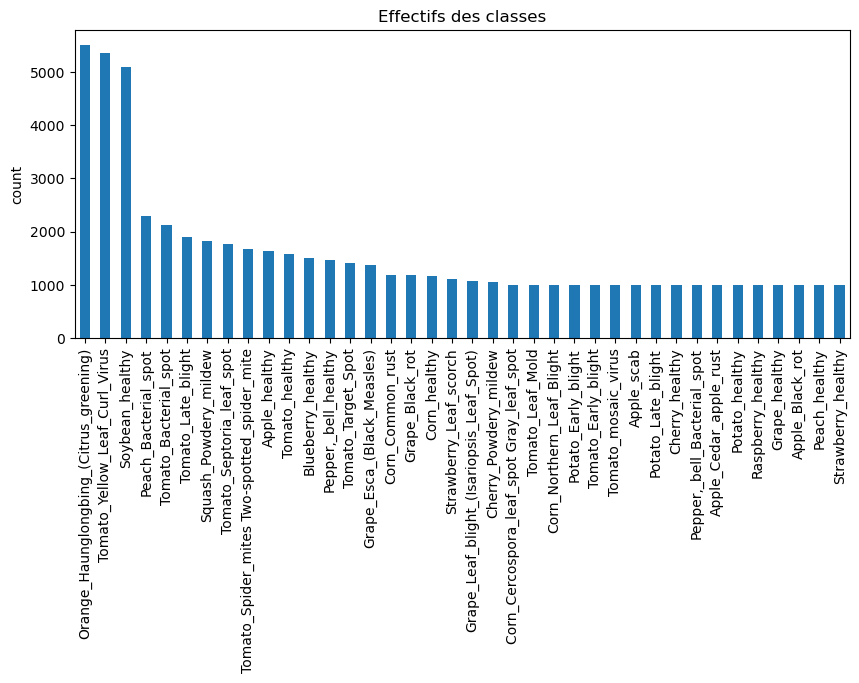

In [6]:
#
# distribution des classes
#
FIGSIZE = (10, 4)

disease_count = pv_dataframe["label"].value_counts()
disease_count.sort_values(inplace=True, ascending=False)

plt.figure(figsize=FIGSIZE)
disease_count.plot.bar(title="Effectifs des classes", ylabel="count")
plt.show()

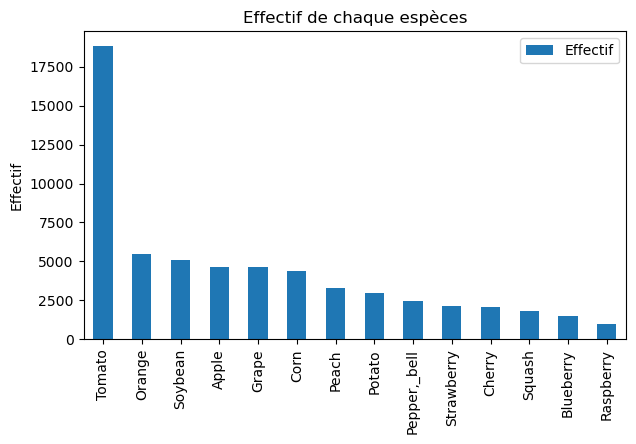

species,Tomato,Orange,Soybean,Apple,Grape,Corn,Peach,Potato,"Pepper,_bell",Strawberry,Cherry,Squash,Blueberry,Raspberry
Effectif,18835,5507,5090,4645,4639,4354,3297,3000,2478,2109,2052,1835,1502,1000


In [7]:
#
# relation species/label
#
doi = pv_dataframe[["label", "species"]]

disease_samples_per_species = doi.groupby("species") \
                                 .count() \
                                 .rename(columns={"label": "Effectif"})
disease_samples_per_species.sort_values("Effectif", inplace=True, ascending=False)

plt.figure(figsize=(7, 4))
disease_samples_per_species.plot.bar(ax=plt.gca(), 
                                     xlabel="", 
                                     ylabel="Effectif")

plt.title("Effectif de chaque espèces")
plt.show()

display( disease_samples_per_species.T )

<font class="answer">
On observe qu'il y a un débalancement dans la répartition des classes et des espèces.

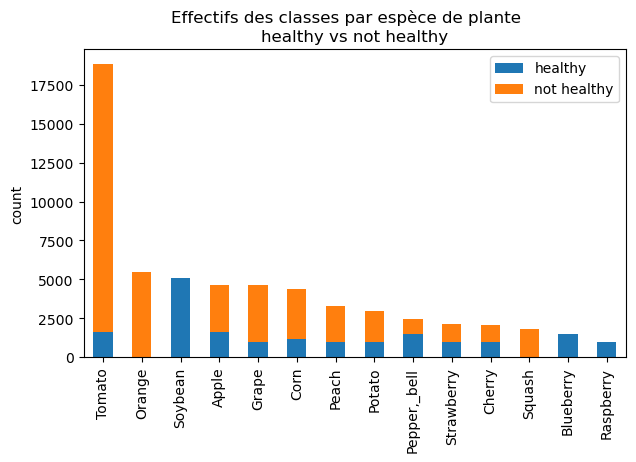

species,Tomato,Orange,Soybean,Apple,Grape,Corn,Peach,Potato,"Pepper,_bell",Strawberry,Cherry,Squash,Blueberry,Raspberry
healthy,1591.0,0.0,5090.0,1645.0,1000.0,1162.0,1000.0,1000.0,1478.0,1000.0,1000.0,0.0,1502.0,1000.0
not healthy,17244.0,5507.0,0.0,3000.0,3639.0,3192.0,2297.0,2000.0,1000.0,1109.0,1052.0,1835.0,0.0,0.0


In [8]:
#
# relation healthy et autres maladies
#
healthy_crit = doi["label"].str.contains("healthy")

healthy = doi[healthy_crit]
healthy = healthy \
            .groupby("species") \
            .count() \
            .rename(columns={"label": "healthy"})

not_healthy = doi[ ~healthy_crit ]
not_healthy = not_healthy \
                .groupby("species") \
                .count() \
                .rename(columns={"label": "not healthy"})

healthy_vs_other_per_species = pd.merge(healthy, 
                                        not_healthy,
                                        how="outer",
                                        on="species")

# pour faciliter la comparison, garder le meme ordre que disease_samples_per_species
healthy_vs_other_per_species = healthy_vs_other_per_species \
                                   .reindex(disease_samples_per_species \
                                   .index.to_list())

fig = plt.figure(figsize=(7, 4))
fig.suptitle("Effectifs des classes par espèce de plante")

healthy_vs_other_per_species.plot.bar(ax=plt.gca(),
                                      stacked=True, 
                                      xlabel="",
                                      ylabel="count")
plt.title("healthy vs not healthy")
plt.show()

display(healthy_vs_other_per_species.replace(np.nan, 0).T)

<font class="answer">

TODO: reformuler par objectif de classifier
    
Nous désirons ignorer les espèces qui ne sont pas représentées dans les deux momdalités (healthy et not healthy). Blueberry, Soybean, Rasberry, Squash et Orange ont donc été écarté.

In [9]:
to_remove = ["Blueberry", "Soybean", "Rasberry", "Squash", "Orange"]
to_remove = pv_dataframe["species"].isin(to_remove)

pv_dataframe_filtered = pv_dataframe[~to_remove]

In [10]:
effectifs_maladie_espece = pv_dataframe_filtered.groupby(["species", "label"]) \
                                                .size() \
                                                .to_frame() \
                                                .rename(columns={0: "Effectif"})
display_html(f"<b>Effectifs des maladies de chaque espèce</b>")
display(effectifs_maladie_espece)

Effectif
species      label                                                
Apple        Apple_Black_rot                                  1000
             Apple_Cedar_apple_rust                           1000
             Apple_healthy                                    1645
             Apple_scab                                       1000
Cherry       Cherry_Powdery_mildew                            1052
             Cherry_healthy                                   1000
Corn         Corn_Cercospora_leaf_spot Gray_leaf_spot         1000
             Corn_Common_rust                                 1192
             Corn_Northern_Leaf_Blight                        1000
             Corn_healthy                                     1162
Grape        Grape_Black_rot                                  1180
             Grape_Esca_(Black_Measles)                       1383
             Grape_Leaf_blight_(Isariopsis_Leaf_Spot)         1076
             Grape_healthy                                    1000
Peach        Peach_Bacterial_spot                             2297
             Peach_healthy                                    1000
Pepper,_bell Pepper,_bell_Bacterial_spot                      1000
             Pepper,_bell_healthy                             1478
Potato       Potato_Early_blight                              1000
             Potato_Late_blight                               1000
             Potato_healthy                                   1000
Raspberry    Raspberry_healthy                                1000
Strawberry   Strawberry_Leaf_scorch                           1109
             Strawberry_healthy                               1000
Tomato       Tomato_Bacterial_spot                            2127
             Tomato_Early_blight                              1000
             Tomato_Late_blight                               1909
             Tomato_Leaf_Mold                                 1000
             Tomato_Septoria_leaf_spot                        1771
             Tomato_Spider_mites Two-spotted_spider_mite      1676
             Tomato_Target_Spot                               1404
             Tomato_Yellow_Leaf_Curl_Virus                    5357
             Tomato_healthy                                   1591
             Tomato_mosaic_virus                              1000

<font class="answer">

Comme nous avons une grosse base de données nous avons décidé, pour réduire le temps d'exécution et rendre le travail plus facile, de choisir une seule espèce qui contient plus qu'une maladie et des groupes assez équilibrés et des images significatives. Nous allons donc choisir entre Apple, Corn, Grape et Potato. Pour éclairer notre choix nous allons regarder les photos de plus près. 

In [11]:
IMAGES_GRID = (3, 5)

def affichage_image(fruit):
    fruit_crit = pv_dataframe_filtered["species"] == fruit
    fruits = pv_dataframe_filtered[fruit_crit]

    random.seed(42)
    images_indices = random.sample(range(fruits.shape[0]), IMAGES_GRID[0] * IMAGES_GRID[1])
    images_indices.sort()
    images = fruits.iloc[images_indices]

    fig = plt.figure(figsize=(10, IMAGES_GRID[0] * 2.0))

    for i, (image_index, image_data) in enumerate(images.iterrows()):
        plt.subplot(IMAGES_GRID[0], IMAGES_GRID[1], i + 1)
        plt.axis("off")

        species = image_data['species']
        disease = pv.attribute_prettify(species, image_data['label'])
        image = pv_dataset.get_image(image_index)

        plt.title(f"{disease}")
        plt.imshow(image)

    plt.suptitle(fruit)
    plt.tight_layout()
    plt.show()

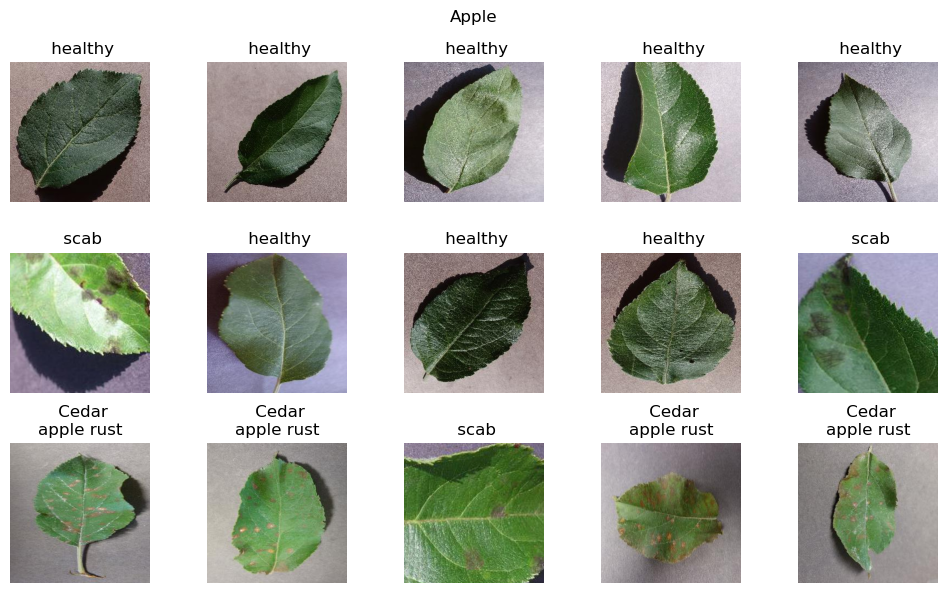

In [12]:
affichage_image("Apple")

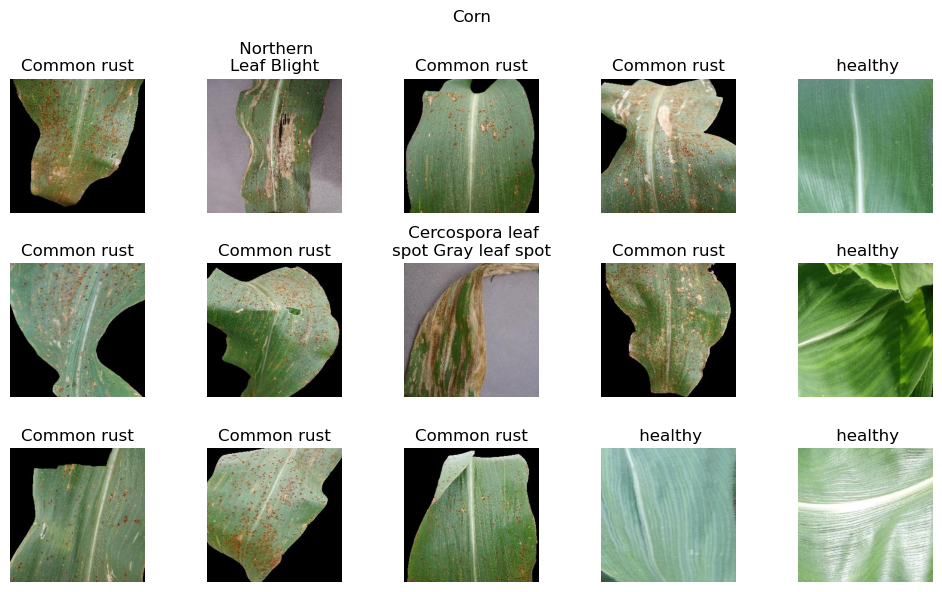

In [13]:
affichage_image("Corn")

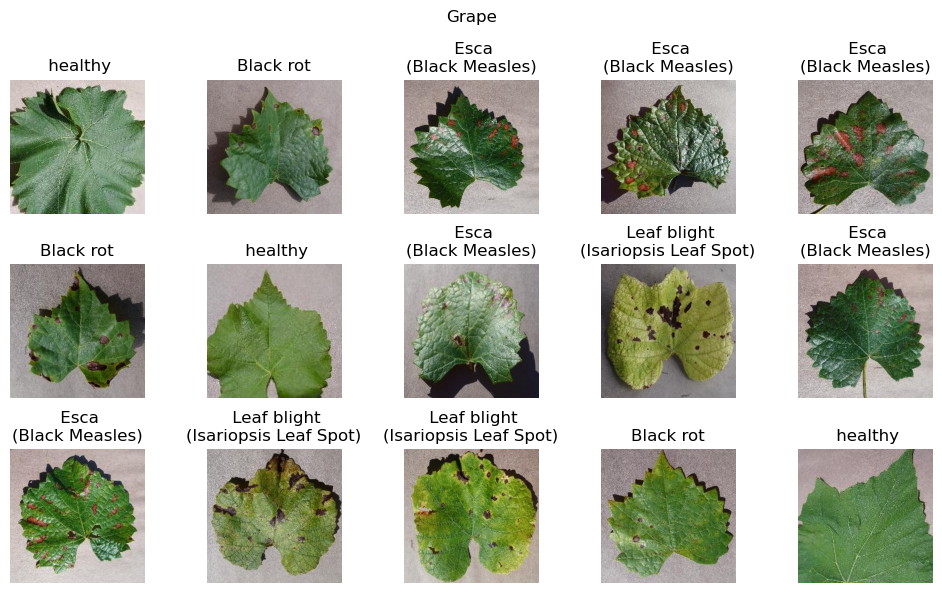

In [14]:
affichage_image("Grape")

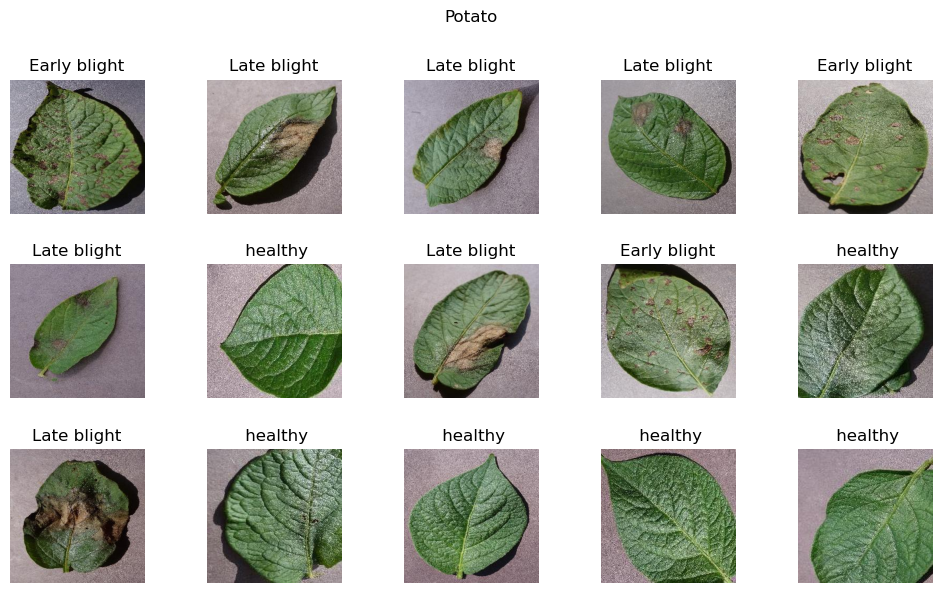

In [15]:
affichage_image("Potato")

<font class="answer">

En regardant les photos de plus près nous avons constaté que pour les species Apple,Corn et Potato les différences entre les photos des différentes maladies sont moins significatives que pour Grape c'est pourquoi nous avons choisi de garder celle-ci.

In [16]:
#
# Équilibrage des groupes de Grape
#

to_include = ["Grape", "Apple"]
to_include = pv_dataframe_filtered["species"].isin(to_include)

pv_dataframe_selected = pv_dataframe_filtered[to_include]

image_indices = pv_dataframe_selected.index.values.reshape(-1, 1)
image_label = pv_dataframe_selected["label"].values.reshape(-1, 1)
image_indices_bal, image_label_bal = RandomUnderSampler(random_state=42).fit_resample(image_indices, image_label)

# validation du balancement
validation_df = pv_dataframe_selected.loc[np.ravel(image_indices_bal), "label"]
display(validation_df.value_counts().to_frame().rename(columns={"label": "Effectif"}))

,Effectif
Apple_Black_rot,1000
Apple_Cedar_apple_rust,1000
Apple_healthy,1000
Apple_scab,1000
Grape_Black_rot,1000
Grape_Esca_(Black_Measles),1000
Grape_Leaf_blight_(Isariopsis_Leaf_Spot),1000
Grape_healthy,1000


## Question 4
**Procéder à la séparation train/test (80-20) de votre dataset original (seed 44)**

In [17]:
#
# Préparation de deux ensembles train/test pour le reste des étapes
#
x_train, x_test = train_test_split(image_indices_bal, stratify=image_label_bal, test_size=0.2, random_state=44)

# validation size des ensembles train/test
print("Data size:", len(image_indices_bal))
print("Train size:", len(x_train))
print("Test size:", len(x_test))

#
# sauvegarde pour injecter dans notre pipeline de traitement
#
split.save(configs.split, np.ravel(x_train), np.ravel(x_test))

Data size: 8000
Train size: 6400
Test size: 1600


# Bag of Visual Words

<font class="answer">
   
TODO: Mettre description de la technique et de notre pipeline

## Extraction des "key points" et descripteurs avec la méthode SIFT

<font class="answer">
   
Pour alléger le document, nous montrons seulement le traitement fait sur la méthode SIFT. La méthode ORB se trouve en annexe (les résultats étaient moins satisfaisant).

In [18]:
#
# relecture train/test sets
# 
train, test = split.load(configs.split)

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "sift_" in locals():
    del sift_

#
# Extraction
#
sift_iter = feat.DatasetIter(pv_dataset, 
                             pv_dataframe.loc[train + test, "image_path"].items(),
                             len(train + test))

# la premiere execution va mettre en cache les resultats
configs.sift.read_only = False
sift_ = feat.load(configs.sift, sift_iter)
if configs.sift.force_generate or sift_.train_descriptors is None:
    feat.update_train_test(sift_, train, test)

print("SIFT descripteurs:", sift_.descriptors.shape)
print("SIFT key_points", sift_.key_points.shape)
print("SIFT train descripteurs", sift_.train_descriptors.shape)
print("SIFT test descripteurs", sift_.test_descriptors.shape)

SIFT descripteurs: (2045110, 128)
SIFT key_points (2045110, 7)
SIFT train descripteurs (1634059, 128)
SIFT test descripteurs (411051, 128)


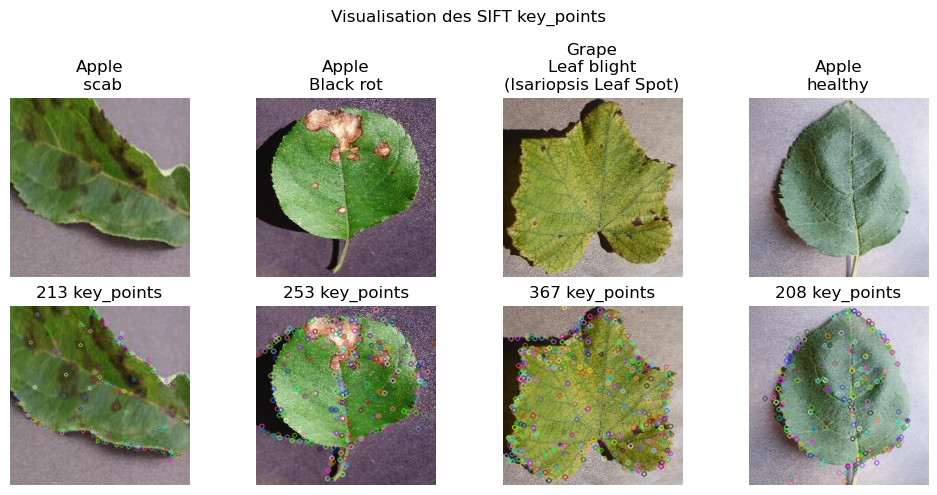

In [26]:
SAMPLES_GRID = (2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)
        
def affiche_key_points(method_, image_indices):
    _, axes = plt.subplots(SAMPLES_GRID[0], SAMPLES_GRID[1], figsize=FIGSIZE)
    
    for i, image_index in enumerate(image_indices):
        key_points = method_.index_to_key_points[str(image_index)][...]
        
        image = pv_dataset.get_image(image_index)
        image_key_points = feat.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[0, i])
        plt.title(title)
        plt.axis("off")
        plt.imshow(image)
        
        plt.sca(axes[1, i])
        plt.title(str(len(key_points)) + " key_points")
        plt.axis("off")
        plt.imshow(image_key_points)


# selectionner quelques images aleatoirement
random.seed(55)
indices = random.sample(train, SAMPLES_GRID[1])
indices.sort()

#
# visualiser quelques sift keypoints
#
affiche_key_points(sift_, indices)

plt.suptitle("Visualisation des SIFT key_points")
plt.tight_layout()
plt.show()

Etant donnée que les descripteurs des images représentent un apport important à la quantité de données à traiter (14 382 049 de descripteurs pour 3 711 images, plus de 3 ordres de grandeurs en quantité), nous voulons optimiser cet impact. Une analyse PCA nous permettra de les transformer pour éventuellment réduire leurs dimensions. 

In [ ]:
def features_pca(x):
    pca_pipeline = Pipeline([("scaler", StandardScaler()),
                             ("pca", PCA(svd_solver="full"))])
    pca_pipeline.fit(x)
    return pca_pipeline

def features_pca_analysis(pca_model, title_prefix, threshold=None, figsize=(5, 3)):
    var_ratio = pca_model.explained_variance_ratio_
    inertia = np.cumsum(var_ratio)

    plt.figure(figsize=figsize)
    plt.plot(range(inertia.shape[0]), inertia, marker=".")
    if not threshold is None:
        plt.axhline(y=threshold, color="red", linestyle="-")
    plt.grid()
    plt.title(f"{title_prefix}\n% variance expliquée vs # composantes")
    plt.show()

In [ ]:
with hlp.Profile() as orb_features_pca_profile:
    orb_features_pca = features_pca(orb_features.train_features)

print("ORB Features PCA:", orb_features_pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(orb_features_pca["pca"].explained_variance_)

features_pca_analysis(orb_features_pca["pca"], "ORB", 0.95)

Le graphique précédant n'exhibe pas de "coude franc". Nous établisons donc un seuil à 95% ce qui permet de garder 26 composantes sur les 32 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.  

In [ ]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as orb_bovw_profile:
    orb_bovw = vw.load_bovw(configs.orb_bovw, orb_features.train_features)

print("ORB BoVW loading:", orb_bovw_profile.round_duration(), "s")
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)

In [ ]:
with hlp.Profile() as sift__pca_profile:
    sift__pca = features_pca(sift_.train_descriptors)

In [ ]:
print("ORB Features PCA:", sift__pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(sift__pca["pca"].explained_variance_)

features_pca_analysis(sift__pca["pca"], "SIFT", 0.95, (8, 4))

De la même manière que précédement, nous établisons donc un seuil à 95% ce qui permet de garder 80 composantes sur les 128 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.

In [ ]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_.train_descriptors)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# import utilitaires
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.visual_words as vw

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

# pour update tf-idf
configs.orb_bovw.read_only = False
configs.sift_bovw.read_only = False


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()

#
# orb
#
orb_features = feat.load(configs.orb, None)
orb_bovw = vw.load_bovw(configs.orb_bovw, None)

print("ORB features:", orb_features.features.shape)
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)
print()


#
# sift
#
sift_ = feat.load(configs.sift, None)
sift_bovw = vw.load_bovw(configs.sift_bovw, None)

print("Sift features:", sift_.descriptors.shape)
print("Sift BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# export en batch des visual words orb
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "orb_pv_vw" in locals():
    del orb_pv_vw

with hlp.Profile() as orb_pv_vw_loading:
    orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                                   orb_features,
                                   configs.orb_bovw,
                                   orb_bovw,
                                   train,
                                   test)
    
print(f"ORB PlantVillage Visual Word loading:", orb_pv_vw_loading.round_duration(), "s")
print("ORB PlantVillage Visual Words", orb_pv_vw.vw_freqs.shape)

In [ ]:
# a = np.ravel( orb_bovw.idf )
# b = np.ravel( orb_pv_vw.index_to_vw_freqs["46984"] )
# c = np.multiply(a, b)

# plt.figure( figsize=(10, 6) )

# plt.subplot(311)
# plt.title("idf")
# plt.bar(range(500), a)

# plt.subplot(312)
# plt.title("tf")
# plt.bar(range(500), b)

# plt.subplot(313)
# plt.title("tf-idf")
# plt.bar(range(500), c)

# plt.tight_layout()
# plt.show()

In [ ]:
#
# export en batch des visual words sift
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw, 
                                    sift_,
                                    configs.sift_bovw,
                                    sift_bovw,
                                    train,
                                    test)

print(f"sift PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("sift PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

In [ ]:
SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_image(image_indices, bovw, features, pv_vw):
    x_range = range(bovw.cluster_centers.shape[0])
    idf = np.ravel(bovw.idf)
    
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = feat.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")

In [ ]:
# selectionner quelques images aleatoirement
random.seed(33)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

#
# visualiser quelques visual words orb
#
affiche_image(image_indices,
              orb_bovw,
              orb_features, 
              orb_pv_vw)

plt.suptitle("ORB")
plt.tight_layout()
plt.show() 

In [ ]:
#
# visualiser quelques visual words sift (memes que orb)
#
affiche_image(image_indices,
              sift_bovw,
              sift_, 
              sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 
    
# figure.savefig(f"{vw_title}_visual_words.png")

In [ ]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, \
    f1_score, \
    confusion_matrix, \
    ConfusionMatrixDisplay, \
    calinski_harabasz_score, \
    davies_bouldin_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm.notebook import tqdm

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)

In [ ]:
#
# features sift
#

configs.sift.force_generate = True
configs.sift.read_only = False

if "sift_" in locals():
    del sift_

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe.loc[train + test, "image_path"].items(),
                                 len(train + test))
    sift_ = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT keypoints", sift_.key_points.shape)
print("SIFT features", sift_.descriptors.shape)

if configs.sift.force_generate or sift_.train_descriptors is None:
    feat.update_train_test(sift_, train, test)

print("SIFT train features", sift_.train_descriptors.shape)
print("SIFT test features", sift_.test_descriptors.shape)

In [ ]:
#
# reduction des features (voir notebook precedant pour savoir combien de component on garde sur SIFT)
#

pca_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=configs.sift_bovw.pca_n_components, svd_solver="full", random_state=42))
     ])
sift_train_features_pca = pca_pipe.fit_transform(sift_.train_descriptors);

La litérature est relativement large sur le sujet des clusters. En effet, les techniques de regorupement par densité, par hiéarchie et distance sont toutes explorées. Cependant, nos expérimentations nous ont montrées que seul **MiniBatchKMeans** converge. En effet DBSCAN, SpectralClustering et autres ne terminent pas dans un temps raisonable ou crash tout simplement.

Il est difficile d'évaluer visuellement la qualité de notre clustering etant donné la dimentionalité de nos données. PCA et TSNE ne nous montrent pas un regroupement clair. Nous avons donc opté pour une approche plus simple. A savoir des clusters compactes quitte à avoir beaucoup de chevauchement. Nos métriques sont donc l'inertie (graphe en coude) et **skelarn.metrics.davies_bouldin_score** (recherche valeur minimale). 

* Mettre note pour epliquer **davies_bouldin_score**.
* https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
* https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
* Est-ce que resampler les features auraient du etre fait? Voir graphes et notes dans [06 - Training - Analyse et recommendations](<06 - Training - Analyse et recommendations.ipynb>)

In [ ]:
cluster_range = range(55, 501, 10)
cluster_scores = [[],[]]
for n_clusters in tqdm(cluster_range):
    cluster_model = MiniBatchKMeans(n_clusters=n_clusters,
                                    batch_size=256 * 12,
                                    random_state=42,
                                    n_init="auto")
    cluster_labels = cluster_model.fit_predict(sift_train_features_pca)

    # mesure la similarite entre les clusters; lower is better
    david_boutin = davies_bouldin_score(sift_train_features_pca, cluster_labels)

    # pour trouver un coude
    inertia = cluster_model.inertia_

    # prendre en note les mesures
    cluster_scores[0].append(david_boutin)
    cluster_scores[1].append(inertia)

    

    
# afficher les mesures
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title("davies_bouldin_score")
plt.plot(cluster_range, cluster_scores[0], marker=".")

plt.subplot(122)
plt.title("Model inertia")
plt.plot(cluster_range, cluster_scores[1], marker=".")

plt.tight_layout()
plt.show()

D'après le graphe ci-haut, un bon nombre de clusters serait dans l'interval 100 à 200: minimum marqué par davies_bouldin_score et l'inflexion dans le diagrame de l'inertie semble devenir plutôt linéaire. Notre choix s'arrête donc sur 175. Cette information sera intégrée via nos fichiers de configuration.

In [ ]:
#
# bovw sift
#

configs.sift_bovw.force_generate = True

if "sift_bovw" in locals():
    del sift_bovw

# soyez patient, ce n'est pas interactif
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_.train_descriptors)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# dataset vw sift
#

configs.sift_dataset_vw.force_generate = True

if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                   sift_,
                                   configs.sift_bovw,
                                   sift_bovw,
                                   train,
                                   test)
    
print(f"SIFT PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("SIFT PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

In [ ]:
#
# visualiser quelques visual words sift
#

SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_vw(image_indices, bovw, features, pv_vw):
    x_range = range(bovw.cluster_centers.shape[0])
    idf = np.ravel(bovw.idf)
    
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = feat.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")
    

# selectionner quelques images aleatoirement
random.seed(55)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

affiche_vw(image_indices,
           sift_bovw,
           sift_, 
           sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 

In [ ]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# sift_pv_vw* garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
sift_train_x = np.multiply(sift_pv_vw.train_vw_freqs[...], sift_bovw.idf)
sift_test_x = np.multiply(sift_pv_vw.test_vw_freqs[...], sift_bovw.idf)

assert sift_train_x.shape[0] == train_y.shape[0]
assert sift_test_x.shape[0] == test_y.shape[0]

print("SIFT PlantVillage train Visual Words", sift_train_x.shape)
print("SIFT PlantVillage test Visual Words", sift_test_x.shape)

Validation de **sift_train_x** juste avant la classification. On veut s'assurer qu'il y ait très peu de corrélation entre les featues.

In [ ]:
# transpose parce que numpy veux les variables dans les rangees
corr = np.corrcoef( sift_train_x.T )

# enlever 1 et -1
corr_no_one = np.where(np.isclose(corr, 1), 0, corr)
corr_max = np.max(corr_no_one)
corr_min = np.min(corr_no_one)

CORR_THRESHOLD = 0.6
corr_thresholded = np.where(abs(corr) > CORR_THRESHOLD, corr, 0)


plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.heatmap(corr, cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title(f"corrélation > abs({CORR_THRESHOLD})")
sns.heatmap(corr_thresholded, cbar=False)
plt.xticks([])
plt.yticks([])

plt.suptitle(f"Corrélation heatmap {corr.shape}\nmin: {round(corr_min, 3)}, max: {round(corr_max, 3)}")
plt.tight_layout()
plt.show()

In [ ]:
def load_knn(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5
        
        pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn", KNeighborsClassifier(n_jobs=-1))])

        pipe_parameters = {"knn__n_neighbors": range(1, 5),
                           "knn__weights": ["uniform", "distance"]}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_knn(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "KNN n_neighbors:", pipe.named_steps["knn"].n_neighbors)
    print(method_name, "KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "KNN f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - KNN - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()

#
# SIFT KNN
#
sift_knn_pipe = load_knn("models/sift_knn.pkl", sift_train_x, train_y)
analysis_knn("SIFT", sift_knn_pipe, sift_test_x, test_y)

In [ ]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier(random_state=42, n_jobs=-1))])

        pipe_parameters = {"forest_gump__n_estimators": range(50, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "Random f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    

#
# SIFT Random Forest
#
sift_rf_pipe = load_rf("models/sift_random_forest.pkl", sift_train_x, train_y)
analysis_rf("SIFT", sift_rf_pipe, sift_test_x, test_y)

# Annexe A - Aspect logiciel

<font class="answer">
    
Les objectifs secondaires de ce projet étaient d'abord se familiariser avec des données un peu plus complexes par leur volumes et par leur nature puis d'adresser le travail collaboratif. En effet, en milieu de travail ou non, le partage de résultats et le temps d'itération sont des facteurs déterminant pour le succès. Cette section détaillera les solutions que nous proposons.

## Organisation du travail

<font class="answer">

Notre approche à haut niveau s'apparente à un "pipeline": chaque coéquipier se concentre sur une étape et produit un fichier qui pourra être consommé par l'étape suivante. Ceci permet de decoupler les tâches afin de travailer en parralèle.

Des modules python permettent de définir les interface de chaque étapes (et d'éviter la duplication d'information) ainsi que les opérations nécessaire. Un effet secondaire bénifique de cette approche est la configurabilité: aucun code n'a besoin d'être modifié pour expérimenter, seulement les paramètres exposés par les interfaces. Dans un but de centralisation, ces paramètres sont exposés à travers un fichier .json (config_overrides.json). Finalement git est utilisé pour suivre l'évolution et communiquer les changements à toute l'équipe.

<br>

<div class="columns_2">
Structure des fichiers
<img src="images/structure_fichiers.png" width="50%">
</div>


<div class="columns_2">
Structure des modules python
<img src="images/modules_python.png" width="35%">
</div>
    
    
| Module python | Responsabilité |
|--|:--|
| helpers| Encapsulation des fonctionalités communes (multithreading, configurations, affichage) |
| dataset/PlantVillage| Encapsupation de la base de données. S'occupe du prétraitement et d'obtenir les pixels des images |
| features | Encapsulation du traitement fait sur les images (l'extraction des keypoints et descripteurs, etc) |
| visual_words | Encapsulation de tout ce qui touche au dictionnaire (conversion des descripteurs, histograme) |
| split | Encapsulation de l'information des ensembles d'entraînement et test |        

## Reproductibilité des résultats

<font class="answer">
    
Il nous apparait important de s'assurer que toute personnes voulant reproduire les résultats puissent le faire sans trop se soucier des détails d'implémentations. Chaque interface intégre ce concept en augmentant le fichier .json pour automatiser son processus interne et en mettant en cache les résultats pertinants. Par exemple, le module dataset/PlantVillage s'occupe du téléchargement de la base de données et du prétraitement lors de la première execution. L'utilisateur n'a pas à se soucier de rien: il obtiendra toujours un dataframe formater de la même manière. Exemple de configuration:
    
```json
"dataset": {
    "url": "https://tinyurl.com/22tas3na",
    "install_path": "dataset/PlantVillage.hd5"
}
```
    
Le contrôle de l'environment de dévelopmement est également important. Nous avons adressé ce problème avec les environments d'Anaconda et python. *conda_requirements.yaml* et *requirements.txt* listent les diverses libraires utilisées et leurs versions.

## Temps d'itération

<font class="answer">

Une partie de la complexité de notre projet tente d'adresser le temps d'itération. En effet, une itération naîve peut devenir très problématique lorque nous avons à manipuler des millions d'éléments. Nous avons adressé ce problème sur deux fronts: le multithreading pour l'aspect calcul de résultats et le format HDF5 pour la persistence de ceux-ci.

### Multithreading

<font class="answer">
    
sklearn gère en partie le multithreading. Nous avons prêté attention aux paramètres lors de la construction de certains objets. Par contre, toutes les classes ne sont pas équivalentes: le clustering a imposé une contrainte. Sinon la documentation est très informative. Exemple lors du calcul du dictionnaire:
    
```python
...
("kmeans", MiniBatchKMeans(n_clusters=config.kmeans_n_clusters,
                           batch_size=256 * cpu_count(), # maximiser l'utilisation CPU
                           n_init="auto"))])
...
```

Pour les cas qui n'ont pas de support avec sklearn, le module helpers expose la classe Concurrent. Elle offre une solution simple pour parraléliser une boucle. A titre d'exemple, l'extraction des keypoints et des descripteurs sur 5000 éléments est passé de ~60s à ~20s: plus de 50% de gain. Toutes les boucles n'en beneficient pas de façon aussi significative. La conversion des images en histogramme est passer de ~11s à ~9s: un gain plus marginal. Le facteur limitant semble être le [GIL](https://realpython.com/python-gil/) de python. En effet, par design, python ne permet l'exécution que d'un seul thread à la fois. Le multiprocessing aurait probablement nous apporter de meilleurs gains mais Jupyter notebook impose des limitations à ce sujet. Nous n'avons donc pas poussé plus loin les optimisations. Exemple de parralélisation:
    

```python
#
# sans parralélisation
#
def fonction_couteuse(parametres, index):
    # operations couteuses ici
    return resultat

resultats = []
for i in range(10000000):
    r = fonction_couteuse(parametres, i)
    resultats.append(r)  
```

<br>
 
```python
#
# avec parralélisation
#
def accumule_resultats(resultats, task_resultat):
    resultats.append(r)

resultats = []
helpers.Concurrent.parallel_for(range(10000000),
                                fonction_couteuse,
                                parametres,
                                task_completed=lambda r: accumule_resultats(resultats, r))
```

### HDF5

<font class="answer">

HDF5 est un format de fichier qui permet de manipuler ses propres données. Son utilisation s'apparente à un dictionaire python (chaque clef peut être considérée comme un fichier) lors de l'écriture et comme un objet numpy lors de la lecture. Il est donc très simple d'intégration. Une particularité intéressante est la possibilité de crééer des vues sur des données existantes: les virtual dataset. Ceci permet d'éliminer complètement les copies redondantes des données. Exemple d'utilisation avec le multithreading. Chaque thread extrait ses résultats de façon indépendante (excellent parralélisme) et construit un index sur ce dernier pour facilité les recherches subséquentes.
    
```python
def _batch_extract(features,
                   bovw_model,
                   n_clusters,
                   h5_file,
                   indices_iterables):
    vw_freqs = np.empty((0, n_clusters), dtype=_VISUAL_WORDS_FREQS_TYPE)
    indices = []

    count = 0
    for index in indices_iterables:
        count += 1

        index_str = str(index)
        if not index_str in features.index_to_features:
            continue

        features_array = features.index_to_features[index_str][...]
        vw_freq = _extract(bovw_model, n_clusters, features_array)
        vw_freq = vw_freq.astype(_VISUAL_WORDS_FREQS_TYPE)
        vw_freq = np.expand_dims(vw_freq, axis=0)

        vw_freqs = np.append(vw_freqs, vw_freq, axis=0)

        indices.append(index)

    if vw_freqs.shape[0] > 0:
        batch_name = str(uuid.uuid4())
        vw_ds = h5_file.create_dataset(batch_name, data=vw_freqs)

        # map each index for later fast query
        for i, index in enumerate(indices):
            layout = h5py.VirtualLayout((1, vw_freqs.shape[1]), dtype=vw_freqs.dtype)
            layout[...] = h5py.VirtualSource(vw_ds)[i, ...]
            h5_file.create_virtual_dataset(f"{_INDEX_TO_VISUAL_WORDS_FREQS_KEY}/{index}", layout)

        batch = MetaObject.from_kwargs(vw_count=vw_freqs.shape[0],
                                       vw_ds_name=batch_name)
    else:
        batch = None

    return count, batch
```

## Leçons tirées

<font class="answer">
    
L'utilisation de git et des modules python ont permis une bonne parralélisation du travail. L'architecture en pipeline y contribue également mais apporte aussi une complexité qui demande une plus grande discipline des coéquipiers.  

L'utilisation de HDF5 nous a permis de simplifier notre architecture. En effet, l'intégration avec sklearn est pratiquement sans friction tout en nous laissant carte blanche sur la structure et évite les redondances dans les données.

Quant au multithreading, notre conclusion est qu'un choix de libraire appropriée est plus avantageux que le support "natif" de python. Son support introduit une complexité dans le dévelopment. Malgré toutes les attentions apportées, nous avons tout de même dû minimiser la quantité d'éléments à traiter pour que le projet reste humainement atteignable.

# Annexe B - Méthode ORB

<font class="answer">
Bla